# Example Notebook for trilepton events

In [10]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea import hist
import pandas as pd
import uproot_methods
import awkward

from memory_profiler import profile

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.helpers import addRowToCutFlow, loadConfig, getCutFlowTable

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [16]:
class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis            = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "pt_spec_max" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "eta_spec_max" :          hist.Hist("Counts", dataset_axis, eta_axis),
            "MT" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :          hist.Hist("Counts", dataset_axis, ht_axis),
            "ST" :          hist.Hist("Counts", dataset_axis, ht_axis),
            "mbj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mjj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_min" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_max" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_min" :          hist.Hist("Counts", dataset_axis, mass_axis),
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_ele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_diele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_mu" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_dimu" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_spec" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "FWMT1" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT2" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT3" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT4" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "FWMT5" :           hist.Hist("Counts", dataset_axis, norm_axis),
            "S" :               hist.Hist("Counts", dataset_axis, norm_axis),
            "S_lep" :           hist.Hist("Counts", dataset_axis, norm_axis),
            'diboson':          processor.defaultdict_accumulator(int),
            'ttbar':            processor.defaultdict_accumulator(int),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTX':              processor.defaultdict_accumulator(int),
            'tW_scattering':    processor.defaultdict_accumulator(int),
            'DY':               processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()

        # load all the default candidates (jets, leptons, ...)

        print (df['genEventSumw_'])
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            goodjet = df['Jet_isGoodJetAll'].content,
            bjet = df['Jet_isGoodBJet'].content,
            jetId = df['Jet_jetId'].content,
            puId = df['Jet_puId'].content,
        )
        jet       = jet[(jet['goodjet']==1)]
        btag      = jet[jet['bjet']==1]
        light     = jet[(jet['goodjet']==1) & (jet['bjet']==0)]
        spectator = jet[(abs(jet.eta)>2.0) & (abs(jet.eta)<4.7) & (jet.pt>25) & (jet['puId']>=7) & (jet['jetId']>=6)] # 40 GeV seemed good. let's try going lower
        leading_spectator = spectator[spectator.pt.argmax()]
        
        ## Leptons
        lepton = JaggedCandidateArray.candidatesfromcounts(
            df['nLepton'],
            pt = df['Lepton_pt'].content,
            eta = df['Lepton_eta'].content,
            phi = df['Lepton_phi'].content,
            mass = df['Lepton_mass'].content,
            pdgId = df['Lepton_pdgId'].content,
        )

        ## Muons
        muon = lepton[abs(lepton['pdgId'])==13]
        dimuon = muon.choose(2)
        OSmuon = (dimuon.i0['pdgId'] * dimuon.i1['pdgId'] < 0)
        dimuon = dimuon[OSmuon]

        ## Electrons
        electron = lepton[abs(lepton['pdgId'])==11]
        dielectron = electron.choose(2)
        OSelectron = (dielectron.i0['pdgId'] * dielectron.i1['pdgId'] < 0)
        dielectron = dielectron[OSelectron]

        ## MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]

        ## Event classifieres
        
        
        ## define selections (maybe move to a different file at some point)
        trilep      = ((df['nLepton']==3) & (df['nVetoLepton']>=3))
        twoJet      = (jet.counts>=2) # those are any two jets
        oneBTag     = (btag.counts>0)
        twoMuon     = ( muon.counts==2 )
        #Zveto_mu    = ( (dimuon.counts<1) )# | (abs(dimuon.mass - 91)>15) )
        Zveto_mu_wide    = ( (abs(dimuon.mass-91.)<15).counts<1 )
        Zveto_ele_wide   = ( (abs(dielectron.mass-91.)<15).counts<1 )
        Zveto_mu_narrow    = ( (abs(dimuon.mass-91.)<10).counts<1 )
        Zveto_ele_narrow   = ( (abs(dielectron.mass-91.)<10).counts<1 )
        met         = (met_pt > 50)
        fwdJet = (spectator.counts>0)
        fwdJet50 = ((leading_spectator.pt>50).counts>0)


        ## work on the cutflow
        output['totalEvents']['all'] += len(df['weight'])

        addRowToCutFlow( output, df, cfg, 'skim',        None, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] ) # entry point
        addRowToCutFlow( output, df, cfg, 'trilep',      trilep, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'twoJet',      trilep & twoJet, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'oneBTag',     trilep & twoJet & oneBTag, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'met50',       trilep & twoJet & oneBTag & met, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'fwd jet',     trilep & twoJet & oneBTag & met & fwdJet, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'fwd jet 50',     trilep & twoJet & oneBTag & met & fwdJet & fwdJet50, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'Zveto_wide',       trilep & twoJet & oneBTag & met & Zveto_mu_wide & Zveto_ele_wide, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )
        addRowToCutFlow( output, df, cfg, 'Zveto_narrow',       trilep & twoJet & oneBTag & met & Zveto_mu_narrow & Zveto_ele_narrow, processes=['TTW', 'TTX', 'diboson', 'ttbar', 'tW_scattering', 'DY'] )


        # preselection of events
        event_selection = trilep & twoJet & oneBTag & met
        
        ## And fill the histograms
        # just the number of electrons and muons
        output['N_ele'].fill(dataset=dataset, multiplicity=electron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_mu'].fill(dataset=dataset, multiplicity=muon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        # N jet and N b without selections on those
        output['N_jet'].fill(dataset=dataset, multiplicity=jet[trilep & met].counts, weight=df['weight'][trilep & met]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[trilep & met].counts, weight=df['weight'][trilep & met]*cfg['lumi'])
        # forward jet properties
        output['N_spec'].fill(dataset=dataset, multiplicity=spectator[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['pt_spec_max'].fill(dataset=dataset, pt=leading_spectator[event_selection & (spectator.counts>0)].pt.flatten(), weight=df['weight'][event_selection & (spectator.counts>0)]*cfg['lumi'])
        output['eta_spec_max'].fill(dataset=dataset, eta=leading_spectator[event_selection & (spectator.counts>0)].eta.flatten(), weight=df['weight'][event_selection & (spectator.counts>0)]*cfg['lumi'])
        
        # something a bit more tricky
        output['N_diele'].fill(dataset=dataset, multiplicity=dielectron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_dimu'].fill(dataset=dataset, multiplicity=dimuon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])

        return output

    def postprocess(self, accumulator):
        return accumulator


In [17]:
overwrite = True
small = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'triLep_small' if small else 'triLep'

from samples import fileset, fileset_small, fileset_3l

# histograms
histograms = []
histograms += ['N_ele', 'N_mu', 'N_diele', 'N_dimu']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = fileset_small
        workers = 1
    else:
        fileset = fileset_3l
        workers = 8
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': workers, 'function_args': {'flatten': False}},
                                      chunksize=500000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()



KeyError: 'genEventSumw_'

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


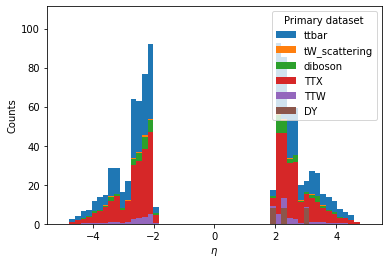

In [34]:
histogram = output['eta_spec_max']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


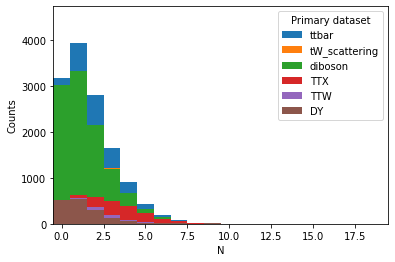

In [38]:
histogram = output['N_jet']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

In [4]:
df = getCutFlowTable(output, processes=['tW_scattering', 'TTW', 'TTX', 'diboson','ttbar', 'DY'], lines=['skim', 'trilep','twoJet','oneBTag','met50', 'fwd jet 50','Zveto_wide', 'Zveto_narrow'])

              tW_scattering          TTW          TTX     diboson  \
skim              46.840054  4453.033199  1703.967749  595.825589   
trilep             0.514726    74.747868   128.956370    0.081547   
twoJet             0.514726    64.056782   117.137959    0.054365   
oneBTag            0.514726    53.742240    83.914733    0.000000   
met50              0.257363    43.051780    56.656219    0.000000   
fwd jet 50         0.257363    12.189746    20.524785    0.000000   
Zveto_wide         0.000000    10.970081     1.417561    0.000000   
Zveto_narrow       0.000000    10.970081     1.417561    0.000000   

                    ttbar            DY  
skim          5415.434989  1.045822e+06  
trilep           0.038867  3.289347e+02  
twoJet           0.159923  1.151931e+02  
oneBTag          0.160328  1.647970e+01  
met50            0.080164  0.000000e+00  
fwd jet 50       0.040082  0.000000e+00  
Zveto_wide       0.000000  0.000000e+00  
Zveto_narrow     0.000000  0.000000e+00  


In [11]:
23.139932/1.484625e+02

0.15586381746232214

In [8]:
output

{'DY': defaultdict_accumulator(int,
                         {'Zveto_narrow': 0,
                          'Zveto_wide': 0,
                          'fwd jet': 0,
                          'fwd jet 50': 0,
                          'met50': 0,
                          'oneBTag': 16.479695804417133,
                          'skim': 1045822.2476198301,
                          'trilep': 328.93472895026207,
                          'twoJet': 115.19307384639978}),
 'FWMT1': <Hist (dataset,norm) instance at 0x7fa85c893d68>,
 'FWMT2': <Hist (dataset,norm) instance at 0x7fa85c893c88>,
 'FWMT3': <Hist (dataset,norm) instance at 0x7fa85c893e80>,
 'FWMT4': <Hist (dataset,norm) instance at 0x7fa85c893da0>,
 'FWMT5': <Hist (dataset,norm) instance at 0x7fa85c893cc0>,
 'HT': <Hist (dataset,ht) instance at 0x7fa85c8939b0>,
 'MET_pt': <Hist (dataset,pt) instance at 0x7fa85c893940>,
 'MT': <Hist (dataset,pt) instance at 0x7fa85c893be0>,
 'N_b': <Hist (dataset,multiplicity) instance at 0x7fa85c893a